In [10]:
import glob
from typing import Dict, List, Tuple
import json
import re

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt
import omegaconf
import numpy as np
import pandas as pd

In [227]:
cfg = omegaconf.OmegaConf.load('mt50_success_plots.yaml')
cfg['in_files']

[{'PaLM2 zeroshot': 'data/ulm340b/chain_py/*-perf.json'}, {'CondAgent zeroshot': 'data/cond_agent_zeroshot-results-*.ndjson'}, {'CondAgent mini oneshot': 'data/cond_agent_mini_oneshot-results-*.ndjson'}, {'CondAgent oneshot': 'data/cond_agent_oneshot-results-*.ndjson'}]

In [228]:
in_files = {}
for pairs in cfg['in_files']:
    for (k, in_pat) in pairs.items():
        in_files.setdefault(k, []).extend(glob.glob(f'../{in_pat}'))

In [7]:
in_files;

In [59]:
CONTENT = ""
def merge_result_files(result_filenames: List[str]) -> Dict[str, List[float]]:
    global CONTENT
    perf = {}
    for filename in result_filenames:
        with open(filename) as f:
            if filename.endswith(".json"):
                data = json.load(f)
            elif filename.endswith(".ndjson"):
                content = f.read()
                CONTENT = content
                objects = re.split(r"\n(?=\{)", content.strip())
                data = json.loads(objects[-1])
            else:
                warnings.warn(f"Could not load file: {filename}")
                data = {}
        for k, v in data.items():
            if k not in perf:
                perf[k] = [v]
            else:
                perf[k].append(v)
    return perf

In [60]:
results = {k: merge_result_files(v) for (k, v) in in_files.items()}

In [65]:
palm2_zeroshot_first = [v[0] for v in results['PaLM2 zeroshot'].values()]

In [210]:
def cumulative_dist(values):
    xs = []
    ys = []
    sorted_vals = sorted(values, reverse=True)
    current_val = sorted_vals[0]
    y = 0
    for i, v in enumerate(sorted_vals):
        y += 1
        if current_val != v:
            if not ys:
                xs.append(v)
                ys.append(0)
            else:
                xs.append(v)
                ys.append(ys[-1])
            xs.append(v)
            ys.append(y)
            current_val = v
    xs.append(v)
    ys.append(y)
    return xs, ys
xs, ys = cumulative_dist(palm2_zeroshot_first)

In [211]:
sorted?

Signature: sorted(iterable, /, *, key=None, reverse=False)
Docstring:
Return a new list containing all items from the iterable in ascending order.

A custom key function can be supplied to customize the sort order, and the
reverse flag can be set to request the result in descending order.
Type:      builtin_function_or_method

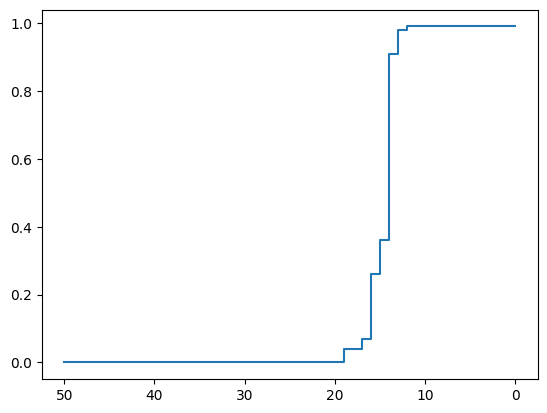

In [212]:
# plt.plot(ys, xs)
fig, ax = plt.subplots()
ax.plot(ys, xs)
ax.invert_xaxis()

In [215]:
np.interp?

Signature: np.interp(x, xp, fp, left=None, right=None, period=None)
Docstring:
One-dimensional linear interpolation for monotonically increasing sample points.

Returns the one-dimensional piecewise linear interpolant to a function
with given discrete data points (`xp`, `fp`), evaluated at `x`.

Parameters
----------
x : array_like
    The x-coordinates at which to evaluate the interpolated values.

xp : 1-D sequence of floats
    The x-coordinates of the data points, must be increasing if argument
    `period` is not specified. Otherwise, `xp` is internally sorted after
    normalizing the periodic boundaries with ``xp = xp % period``.

fp : 1-D sequence of float or complex
    The y-coordinates of the data points, same length as `xp`.

left : optional float or complex corresponding to fp
    Value to return for `x < xp[0]`, default is `fp[0]`.

right : optional float or complex corresponding to fp
    Value to return for `x > xp[-1]`, default is `fp[-1]`.

period : None or float, opt

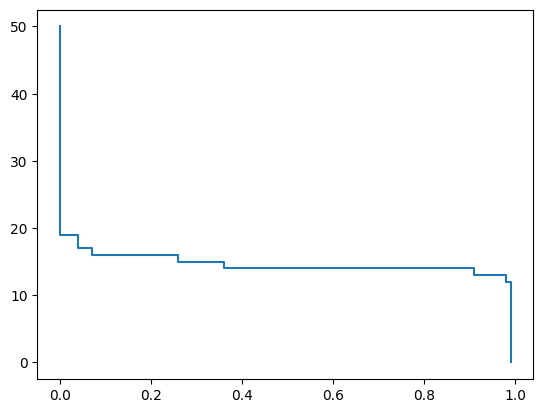

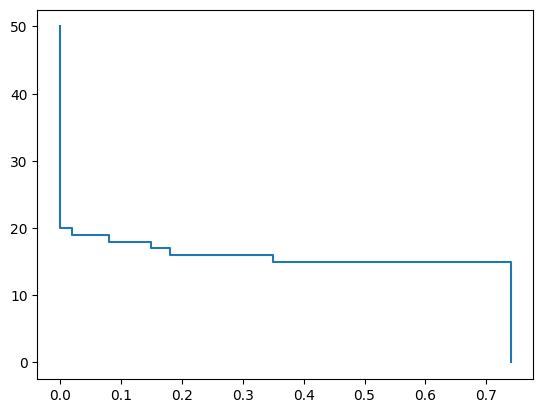

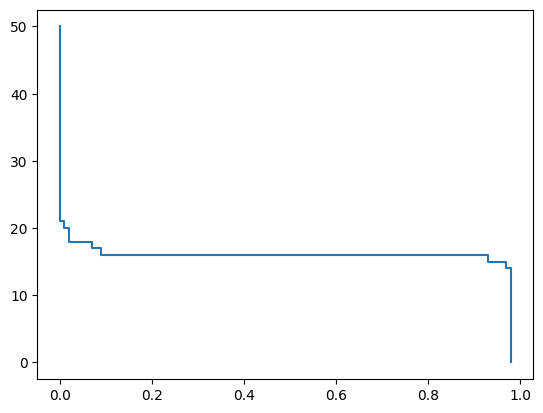

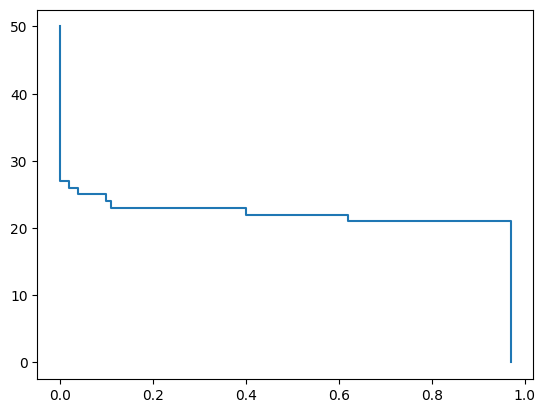

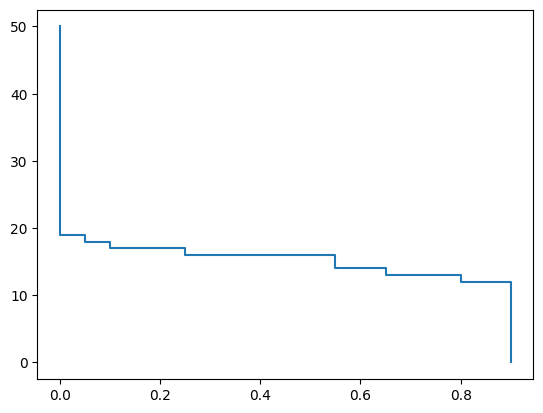

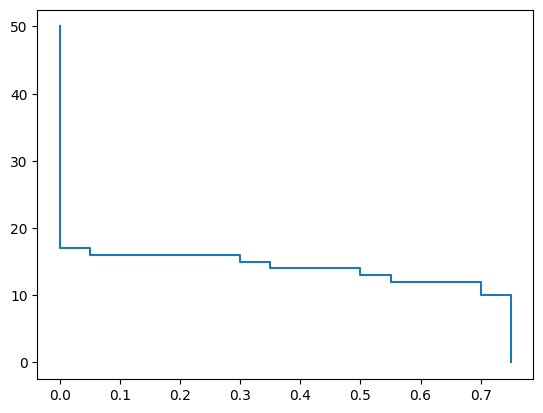

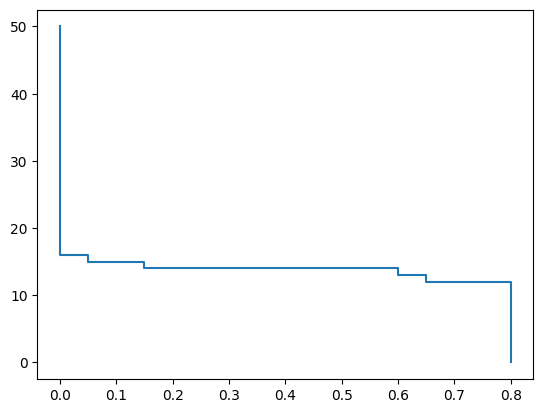

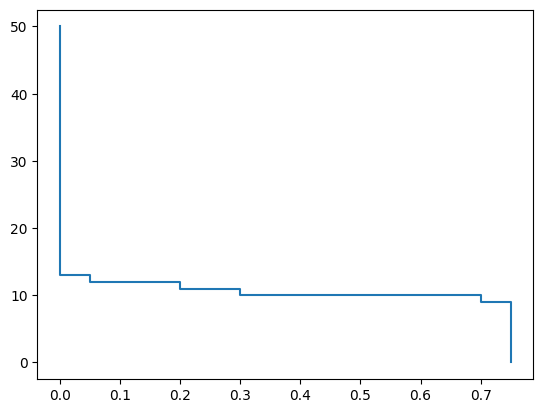

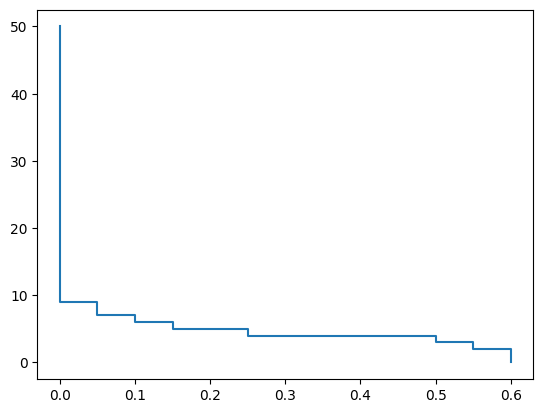

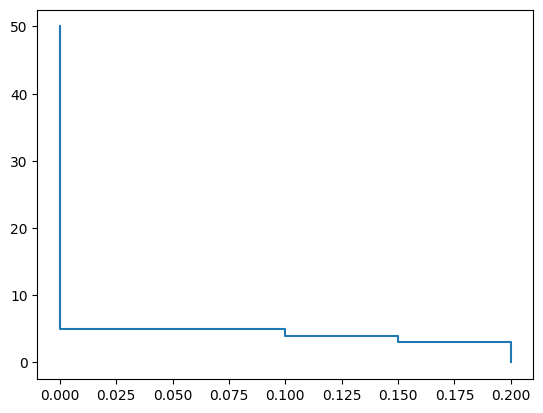

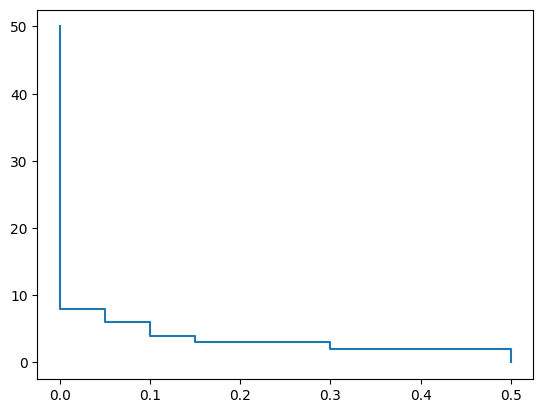

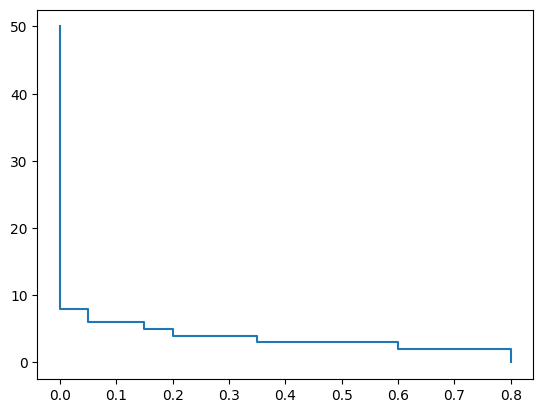

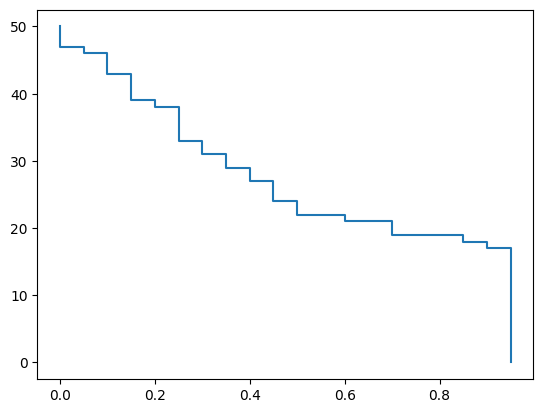

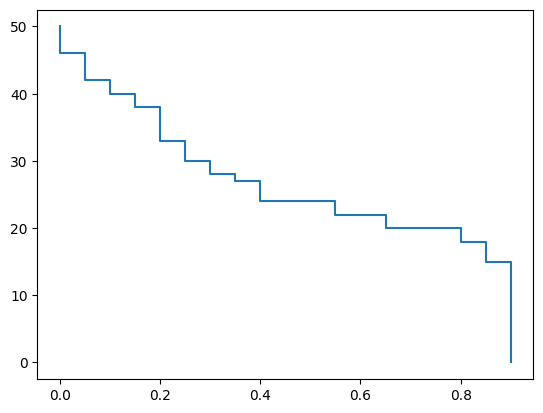

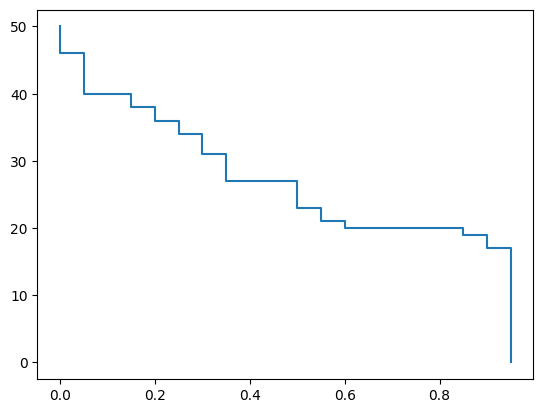

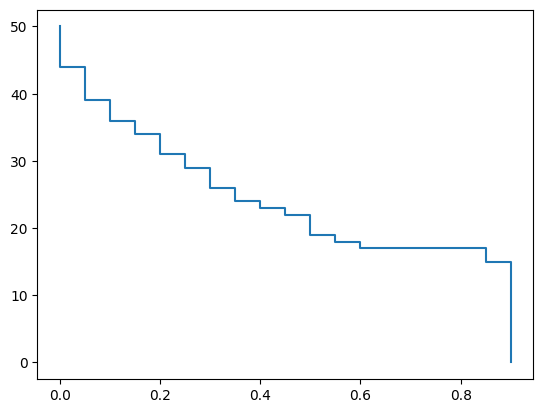

In [222]:
x_results = {}
y_results = {}
entries = []
success_rate_interp = np.linspace(0., 1.0, 51)
num_tasks_interp = np.arange(51)
for result_key, values in results.items():
    x_results[result_key] = []
    y_results[result_key] = []
    for i in range(4):
        if 'assembly/SuccessRate' in values:
            xs, ys = cumulative_dist([vs[i] for (k, vs) in values.items() if 'SuccessRate' in k])
        elif isinstance(next(iter(values.values()))[0], float):
            xs, ys = cumulative_dist([vs[i] for vs in values.values()])
        else:
            raise NotImplementedError()
        x_results[result_key].append(xs)
        y_results[result_key].append(ys)
        # xs = np.interp(success_rate_interp, xs[::-1], ys[::-1])[::-1]
        # ys = num_tasks_interp
        plt.plot(xs, ys)
        plt.show()
        for (x, y) in zip(xs, ys):
            entries.append({
                "Method": result_key,
                "Success Rate": x,
                "Number of Tasks": y,
                "Seed": i,
            })

In [214]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

.. versionchanged:: 1.20.0
    Values are rounded towards ``-inf`` instead of ``0`` when an
    integer ``dtype`` is specified. The old behavior can
    still be obtained with ``np.linspace(start, stop, num).astype(int)``

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is Fals

In [223]:
data = pd.DataFrame.from_records(entries); data

,Method,Success Rate,Number of Tasks,Seed
0,PaLM2 zeroshot,0.99,0,0
1,PaLM2 zeroshot,0.99,12,0
2,PaLM2 zeroshot,0.98,12,0
3,PaLM2 zeroshot,0.98,13,0
4,PaLM2 zeroshot,0.91,13,0
...,...,...,...,...
295,CondAgent oneshot,0.05,39,3
296,CondAgent oneshot,0.05,44,3
297,CondAgent oneshot,0.00,44,3
298,CondAgent oneshot,0.00,47,3


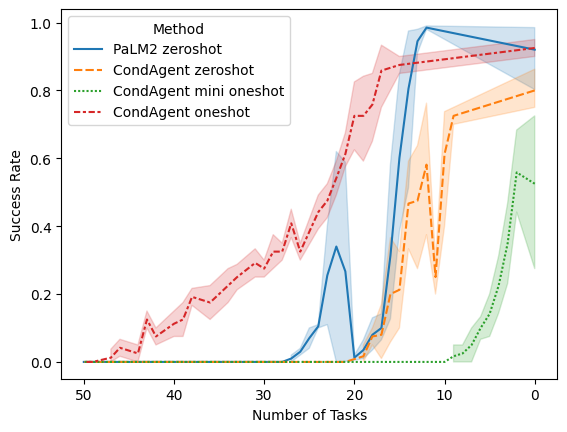

In [224]:
ax = sns.lineplot(data, x="Number of Tasks", y="Success Rate",
                  hue="Method", style="Method")
ax.invert_xaxis()

In [232]:
ax.get_figure().savefig(cfg['out_file'])

In [159]:
len(palm2_zeroshot_first)

50